In this notebook, we will be investigating the latent representations of active matter videos learned by our neural network model called Translational Convolutional Autoencoder (TCAE). Specifically, we will be using PCA to quantify the sparsity of the TCAEs latent space  and visualize its structure. Our goal is to find physical meaning in the representation learned by our neural network.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import glob
import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from TCAE import TConvAutoEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import panel as pn
pn.extension()

In [2]:
experiment_name = "prediction_am_sim_002"
base_dir = os.path.join(os.getcwd(), experiment_name)
weights_dir = os.path.join(base_dir,'weights')
data_dir = os.path.join(os.getcwd(), 'sim_data_112x112/') 
dir_list = sorted(glob.glob(os.path.join(data_dir, '*')))
# Get valid patterns (a single connected region)
valid_patterns = [int(dir_[dir_.find('pattern_') + len('pattern_'):]) for dir_ in dir_list]

In [3]:
# Instatiate model
tcae = TConvAutoEncoder(64)
# dummy data to "connect" the model needed before loading weights
tcae((np.zeros((1,112,112,1)), np.zeros((1,1))))
tcae.load_weights(weights_dir + f'/TCAE_epoch_{29}.h5')

# 64-dimensional embeddings for each video was precomputed to save time
embeddings_64d = np.load(base_dir + '/embedding64d.npy')

In [4]:
def pattern_number2bin_im(pattern):
    """
    Takes an integer in [0-65535], converts it to its binary representation, and reshapes it as a 4x4 binary array
    
    Args:
    pattern (int): integer in [0-65535]
    """
    string_repr = np.base_repr(pattern).zfill(16)
    return np.fromstring(' '.join(string_repr), dtype=int, sep=' ').reshape((4,4))

def bin_im2pattern_number(bin_im):
    """
    Takes an n by m binary numpy array, converts it to a binary string, outputs the decimal representation of the binary number
    
    Args:
    bin_im (numpy array): binary array with shape (n,m) and dtype = 'int'
    """
    string_rep = ''.join(map(str, bin_im.flatten()))
    return int(string_rep, base = 2)

def augment_bin_im(bin_im):
    """
    Takes an n by n binary numpy array and outputs a list of its dihedral group (d4) transformations
    
    Args:
    bin_im (numpy array): binary array with shape (n,n) and dtype = 'int'
    """
    transformed_data = [bin_im] # identity
    for i in range(1,3+1):  
        transformed_data.append(np.rot90(bin_im, k=i, axes=(0, 1))) # rotations
    # Reflections
    transformed_data.append(np.flip(bin_im,axis=0))
    transformed_data.append(np.flip(bin_im,axis=1))
    transformed_data.append(np.transpose(bin_im, axes=(1,0)))
    transformed_data.append(np.transpose(bin_im[::-1,::-1], axes=(1,0)))
    return transformed_data

In [5]:
def heatmap_plot_latent_space(pattern_list, n_rows, n_cols):
    '''
    Takes a list of patterns and for each pattern plots a heatmap of its video's 64-dimensional embedding
    
    Args:
    pattern_list (list): list of pattern numbers whose video's 64-dimensional embedding will be plot
    n_rows (int): number of rows of subplots
    n_cols (int): number of columns of subplots
    '''
    assert all(pattern in valid_patterns for pattern in pattern_list), 'pattern_list contains patterns that are not valid'
    ids = [valid_patterns.index(pattern) for pattern in pattern_list]
    fig, ax = plt.subplots(n_rows, n_cols, dpi = 150)
    k = 0 
    for i in range(n_rows):
        for j in range(n_cols):
            if k < len(pattern_list):
                sns.heatmap(embeddings_64d[ids[k]], cmap = 'magma', cbar = False, vmin = 0, vmax = 100, ax = ax[i,j])
                ax[i,j].set_title(pattern_list[k], fontdict = {'fontsize':8})
                
                # miniature image of the pattern used to produce the video
                imagebox = OffsetImage(pattern_number2bin_im(pattern_list[k]), zoom=2.5, cmap = 'bone')
                imagebox.get_children()[0].set_clim(vmin=0, vmax=1)
                ab = AnnotationBbox(imagebox, (58.3, 0), bboxprops=dict(facecolor='k'), pad = 0.1)
                ax[i,j].add_artist(ab)
                
            # label y axis only first column
            if j == 0:
                ax[i,j].set_ylabel('time')
            else:
                ax[i,j].set_yticks([])
                
            # label x axis only last row
            if i == n_rows-1:
                ax[i,j].set_xlabel('dimension')
            else:
                ax[i,j].set_xticks([])
                
            ax[i,j].tick_params(labelsize=7)
            k += 1
    plt.subplots_adjust(hspace = .5)    

Let's investigate the latent space learned by the TCAE model. TCAE latent space for experiment  `prediction_am_sim_002` was set to 64 dimensions. Each pattern produces a video with size `(170-"time", 112-"height", 112-"width", 1-"channel")` which is converted to `(170-"time", 64-"latent dims")` by the encoder of the TCAE. We can inspect the latent space by plotting the resulting matrices as heatmaps:

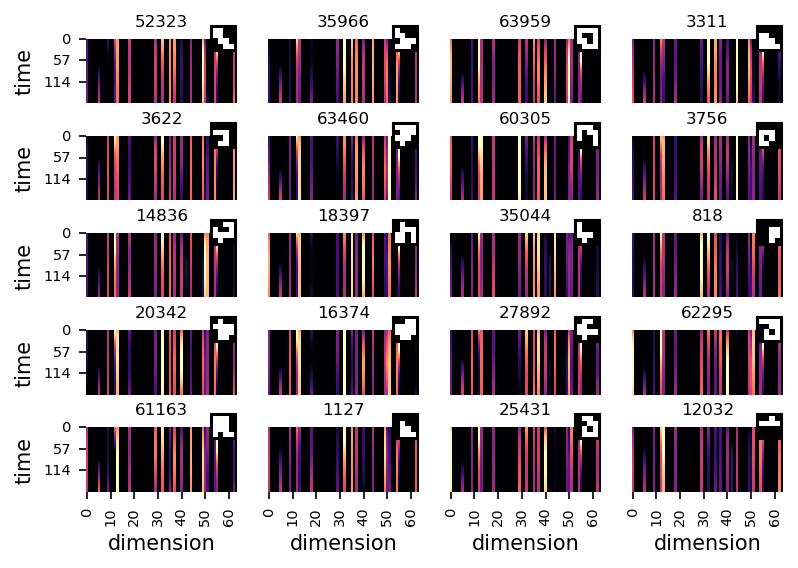

In [6]:
np.random.seed(29) # plot the embeddings of 20 randomly selected videos
heatmap_plot_latent_space([valid_patterns[i] for i in np.random.randint(0, 11500, 20)], 5, 4)

We observe for example that latent dimension `5` seems to get "turned on" in all videos as a function of time. Also we observe that the encoding of the videos is sparse and many of the dimensions remain with zero value.

Using PCA we can reduce the number of dimension further by looking at how many principal components are sufficient to preserve the variance of the data and projecting the embeddings to the top principal components. 

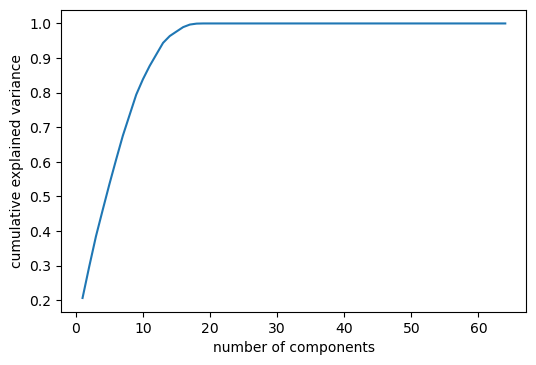

In [7]:
explained_variance_ratio = PCA().fit(embeddings_64d.reshape(170*11506, 64)).explained_variance_ratio_
plt.figure(dpi = 100)
plt.plot(range(1,65), np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [8]:
for i in range(10,20,2):
    print(f'# of components {i}, variance explanied =', np.cumsum(explained_variance_ratio)[i-1])

# of components 10, variance explanied = 0.8385918468734347
# of components 12, variance explanied = 0.91056504676597
# of components 14, variance explanied = 0.9636404924882074
# of components 16, variance explanied = 0.9894274757492496
# of components 18, variance explanied = 0.9995457945858085


14 PCA dimensions are sufficient for capturing > 95% of the "information" contained in the 64-dimensional space. 

In [9]:
pca = PCA(n_components = 14)
embeddings_14d = pca.fit_transform(embeddings_64d.reshape(170*11506, 64))
embeddings_14d = embeddings_14d.reshape(11506,170, 14)

After transforming the 64-dimensional space to 14-dimensional space we can try to reconstruct the original images by performing the inverse PCA transformation followed by the transformation learned by the decoder. The interactive plot below shows a perceptual comparison between: the reconstruction from the 14-dimensional space, the reconstruction from the 64-dimensional space, and the original data. 

6/6 [==============================] - 0s 24ms/step


Column
    [0] Column
        [0] IntSlider(end=170, name='i', value=120)
        [1] IntSlider(end=11506, name='vid', value=5000)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00101')
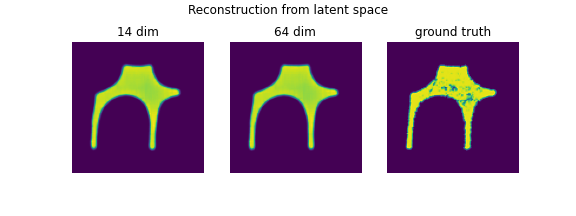

In [10]:
def display(i = 120, vid = 5000):
    reconstruction_14 = tcae.decoder.predict(pca.inverse_transform(embeddings_14d[vid]))
    reconstruction_64 = tcae.decoder.predict(embeddings_64d[vid])
    vid_files = sorted(glob.glob(dir_list[vid] + '/*'))
    ground_truth_im = tf.keras.utils.img_to_array(tf.keras.utils.load_img(vid_files[i], color_mode = "grayscale"))
    f = plt.figure(figsize = (8,3))
    plt.subplot(1,3,1)
    plt.imshow(reconstruction_14[i])
    plt.title('14 dim')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(reconstruction_64[i])
    plt.title('64 dim')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(ground_truth_im)
    plt.title('ground truth')
    plt.axis('off')
    plt.suptitle('Reconstruction from latent space')
    plt.close()
    return f
pn.interact(display,  i = (0, 170), vid = (0, 11506))

Clearly, 14 dimensions are sufficient to represent all the data. 

For visualization, we will project the 64-dimensional embeddings of the videos into only 3 dimensions. 

In [11]:
embeddings_3d = PCA(n_components = 3).fit_transform(embeddings_64d.reshape(170*11506, 64))
embeddings_3d = embeddings_3d.reshape(11506,170, 3)

fig = go.Figure()
step = 21 # downsamples the # of timesteps used for creating a curve
for i in tqdm.tqdm(range(0,11506,10)): # downsamples the # of videos by a factor of 10
    fig.add_trace(
        go.Scatter3d(
            x = embeddings_3d[i,::step,0], 
            y = embeddings_3d[i,::step,1], 
            z = embeddings_3d[i,::step,2], 
            line = dict(color= np.arange(170)[::step], colorbar=dict(thickness=20, title="time")),
            mode ='lines', ))
    
fig.update_layout(
    showlegend=False,
    scene = dict(
                    xaxis_title='PCA 1',
                    yaxis_title='PCA 2',
                    zaxis_title='PCA 3',),
     margin=dict(r=20, b=10, l=10, t=10),
) 
fig.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 2967.75it/s]


The first PCA dimension is strongly correlated with evolution in time.

Now to understand if there is some relationship between the shape of the patterns and their relative location in latent space, we will plot a 2d projection of the representation learned of the start of each video and overlap in the same plot thumbnails of the corresponding patterns.

In [12]:
def plot_2d_embeddings_with_thumbnails(embeddings, color_dim = None, images=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = plt.gca()
    kwargs = {}
    if color_dim is not None:
        kwargs = dict(cmap = 'magma', c = color_dim)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s = 1, **kwargs)
    if images is not None:
        min_dist_2 = (thumb_frac * max(embeddings.max(0) - embeddings.min(0))) ** 2
        shown_images = np.array([2 * embeddings.max(0)])
        for i in range(embeddings.shape[0]):
            dist = np.sum((embeddings[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            if i > 1:
                if np.abs(valid_patterns[i - 1] - valid_patterns[i]) > 2:
                    continue
            shown_images = np.vstack([shown_images, embeddings[i]])
            imagebox = AnnotationBbox(
                OffsetImage(images[i], cmap=cmap, zoom= 4),
                                      embeddings[i], pad = .2)
            ax.add_artist(imagebox)

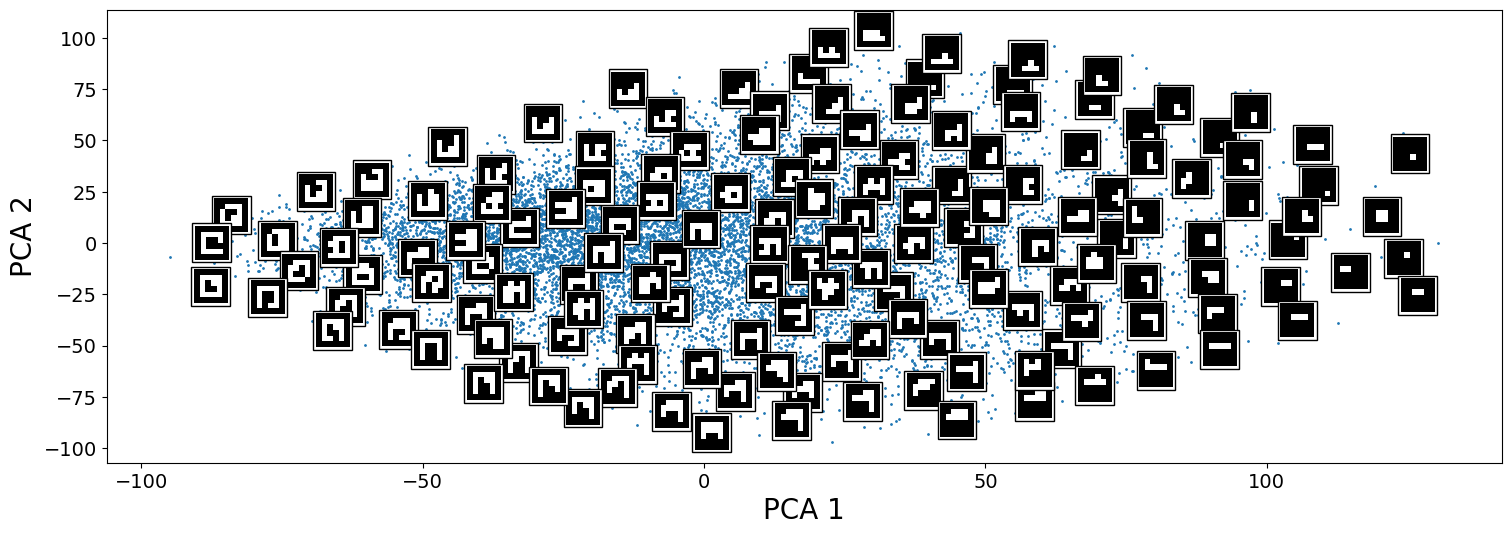

In [13]:
fig, ax = plt.subplots(figsize=(18, 6), dpi = 100)
plot_2d_embeddings_with_thumbnails(PCA(n_components=2).fit_transform(embeddings_64d[:,0,:]),
                images= [np.pad(pattern_number2bin_im(pattern), pad_width=1) for pattern in valid_patterns],
               )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PCA 1', fontdict = {'fontsize':20})
plt.ylabel('PCA 2', fontdict = {'fontsize':20});

We observe that the TCAE latent representation cluster similar shapes together. 

We can also color the scatter plot using a physical quantity we call the bending loss, which is calculated by looking at how much the shape of the microtubule network at final stages of contraction deviates from the original light pattern.  We have already precomputed the bending loss for each pattern.

Bending data: bending is invariant under rotation and reflection of the light pattern. Therefore if multiple patterns are the same under the mentioned transformations, we only calculated the bending loss once. In the next piece of code, we assign the bending loss to patterns for which we did not calculate it directly but instead we calculated the loss of their transformed version.

In [14]:
df = pd.read_csv('gradient_descent_similarity_transformation_best_fit.csv')
rows_list = []
for _, row in df.iterrows():
    for bin_im in np.unique(augment_bin_im(pattern_number2bin_im(row['pattern'])), axis = 0):
        copy_row = row.copy()
        copy_row['pattern'] = bin_im2pattern_number(bin_im)
        rows_list.append(dict(copy_row))
df = pd.DataFrame.from_records(rows_list)
df = df.sort_values(by= 'pattern') 

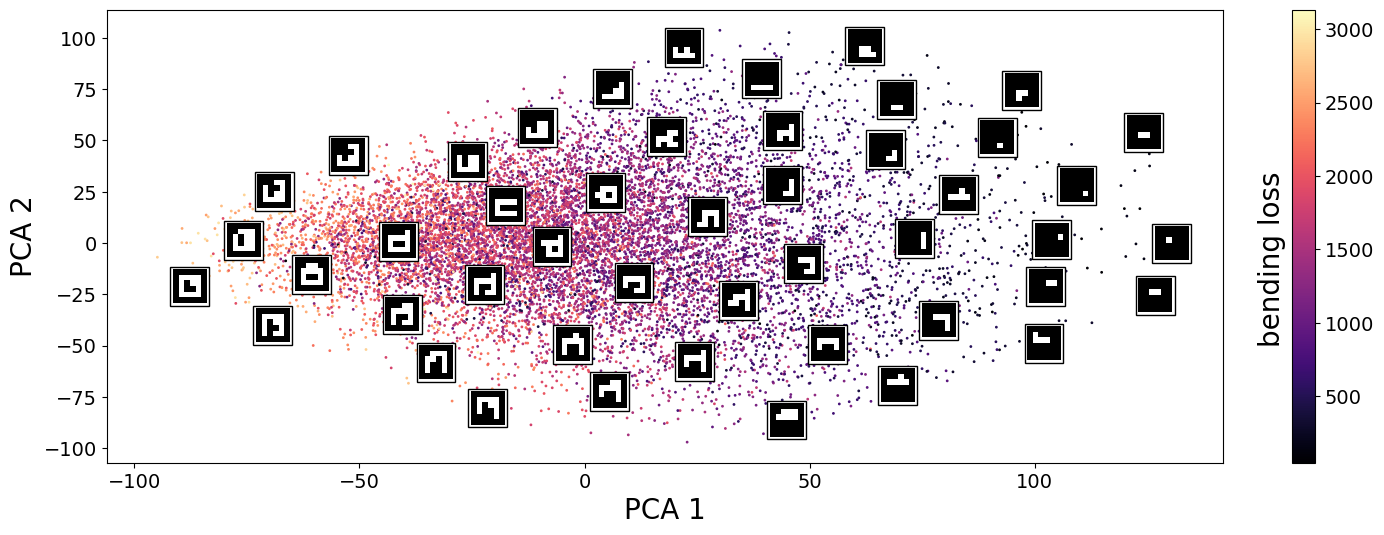

In [15]:
fig, ax = plt.subplots(figsize=(18, 6), dpi = 100)
plot_2d_embeddings_with_thumbnails(PCA(n_components=2).fit_transform(embeddings_64d[:,0,:]),
                df['final_loss'].values,
                images=[np.pad(pattern_number2bin_im(pattern), pad_width=1) for pattern in valid_patterns],
                thumb_frac =.1,
               )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PCA 1', fontdict = {'fontsize':20})
plt.ylabel('PCA 2', fontdict = {'fontsize':20});
cbar = plt.colorbar()
cbar.ax.set_title('bending loss', fontsize=20, loc = 'left', rotation=90, x = -1.5, y = 0.25,)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

It seems that the bending loss is correlated with one of the dimensions of the latent space, which could imply that the bending property of certain shapes is an important feature for the neural network.